In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.signal.windows import triang

import torch
from momentfm import MOMENTPipeline

from finetune import finetune_reflectance

c:\Users\admin\anaconda3\envs\momentts_env\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
df = pd.read_csv("processed_reflectance.csv")
df_all = df.sort_values("timestamp").reset_index(drop=True)

spec_cols = [c for c in df_all.columns if c != "timestamp"]

In [3]:
def plot_reflectance_heatmap(df, spectral_prefix="", 
                             wl_start=400, cmap="RdYlGn",
                             vmin=-0.075, vmax=0.275,
                             title="Reflectance Variation Over Time",
                             figsize=(10,7)):
    """
    Plot time × wavelength reflectance heatmap.
    df must contain a 'timestamp' column and spectral_bin_* columns.
    """

    if "timestamp" not in df.columns:
        raise ValueError("DataFrame must contain a 'timestamp' column.")

    # Spectral columns
    spec_cols = [c for c in df.columns if c != "timestamp"]
    if len(spec_cols) == 0:
        raise ValueError(f"No columns starting with '{spectral_prefix}' found.")

    # Convert values → matrix
    data = df[spec_cols].to_numpy()

    # Wavelength axis
    wl_end = wl_start + len(spec_cols) - 1
    wavelengths = np.arange(wl_start, wl_end + 1)

    # Date labels
    dates = pd.to_datetime(df["timestamp"]).dt.strftime("%Y-%m-%d")

    # Plot
    plt.figure(figsize=figsize)

    plt.imshow(
        data,
        aspect='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=[wavelengths[0], wavelengths[-1], len(df), 0],
        origin='upper'      # time runs from top to bottom
    )

    plt.colorbar(label="Reflectance")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Date")
    plt.title(title, fontsize=14)

    # Y-ticks → readable dates
    yticks = np.linspace(0, len(df)-1, 10).astype(int)
    plt.yticks(yticks, dates.iloc[yticks], rotation=0)

    plt.tight_layout()
    plt.show()

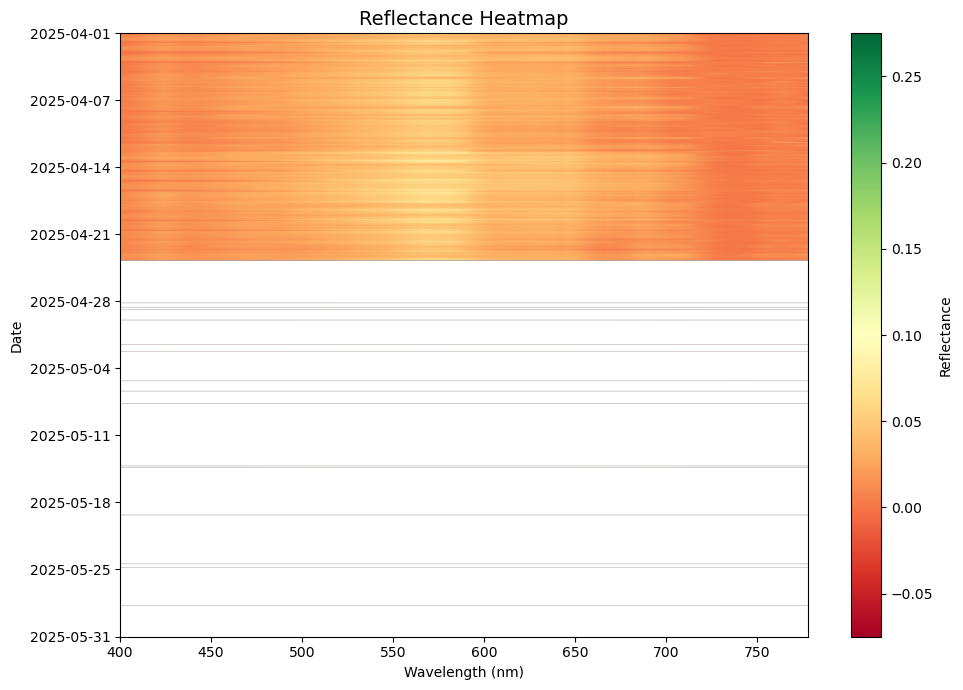

In [4]:
plot_reflectance_heatmap(
    df_all,
    title="Reflectance Heatmap",
)

In [5]:
def interpolate_spectrum_fill_all(y, smooth=True, window=15, poly=3):
    """
    y: 1D array of shape (n_wavelengths,), may contain np.nan.
    Fills *all* gaps (NaNs) in a partially valid spectrum.

    - uses linear interpolation along wavelength
    - extrapolates edges with nearest valid value
    - optional Savitzky–Golay smoothing on the filled curve
    """
    y = y.astype(float)
    x = np.arange(len(y))

    mask = ~np.isnan(y)
    n_valid = mask.sum()

    # No or almost no information → return as is (still NaN)
    if n_valid < 2:
        return y

    x_valid = x[mask]
    y_valid = y[mask]

    # Linear interpolation + edge extrapolation
    # np.interp fills interior by interpolation and outside with boundary values
    y_filled = np.interp(x, x_valid, y_valid)

    if smooth:
        # apply gentle smoothing on the fully filled curve
        if len(y_filled) >= window:
            y_smooth = savgol_filter(y_filled, window_length=window, polyorder=poly)
            return y_smooth
        else:
            # not enough points for this window length
            return y_filled

    return y_filled

# df: your original DataFrame
# spec_cols: list of spectral_bin_* columns, e.g.:
# spec_cols = [c for c in df.columns if c.startswith("spectral_bin_")]

df_processed = df.copy()

is_fully_nan = df_processed[spec_cols].isna().all(axis=1)
is_partially_nan = df_processed[spec_cols].isna().any(axis=1) & ~is_fully_nan

rows_to_work_on = df_processed[is_partially_nan].index

for idx in rows_to_work_on:
    row = df_processed.loc[idx, spec_cols].to_numpy(dtype=float)

    # fill all gaps in that row across all bins
    row_filled = interpolate_spectrum_fill_all(
        row,
        smooth=True,   # set to False if you don’t want smoothing
        window=15,
        poly=3
    )

    df_processed.loc[idx, spec_cols] = row_filled

print("Per-row interpolation complete (all gaps filled in partial rows).")

# Keep fully-NaN rows as they are
df_ready_for_moment = df_processed.sort_values("timestamp").reset_index(drop=True)

print("\nData is now ready.")
print(f"Total rows: {len(df_ready_for_moment)}")
print(
    "Rows with full gaps (still NaN):",
    df_ready_for_moment[spec_cols].isna().all(axis=1).sum()
)

df = df_ready_for_moment.copy()
df

Per-row interpolation complete (all gaps filled in partial rows).

Data is now ready.
Total rows: 2745
Rows with full gaps (still NaN): 1696


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2025-04-01 07:00:00+07:00,0.001028,0.001252,0.001631,0.002151,0.002798,0.003557,0.004413,0.005351,0.006358,...,0.003903,0.003545,0.003151,0.002730,0.002288,0.001835,0.001377,0.000924,0.000483,0.000062
1,2025-04-01 07:15:00+07:00,0.001816,0.001444,0.001316,0.001411,0.001710,0.002191,0.002834,0.003618,0.004524,...,0.006354,0.006246,0.006138,0.006045,0.005977,0.005948,0.005969,0.006055,0.006216,0.006466
2,2025-04-01 07:30:00+07:00,0.005216,0.004338,0.003764,0.003469,0.003430,0.003620,0.004017,0.004596,0.005331,...,0.005148,0.004928,0.004743,0.004613,0.004555,0.004590,0.004736,0.005012,0.005437,0.006030
3,2025-04-01 07:45:00+07:00,0.001160,0.000594,0.000311,0.000288,0.000499,0.000921,0.001528,0.002296,0.003201,...,0.002718,0.002488,0.002314,0.002204,0.002167,0.002213,0.002352,0.002591,0.002941,0.003412
4,2025-04-01 08:00:00+07:00,0.003187,0.003371,0.003642,0.003994,0.004419,0.004912,0.005466,0.006074,0.006729,...,0.003281,0.003293,0.003316,0.003346,0.003383,0.003424,0.003468,0.003512,0.003555,0.003595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2741,2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2742,2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2743,2025-05-31 17:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


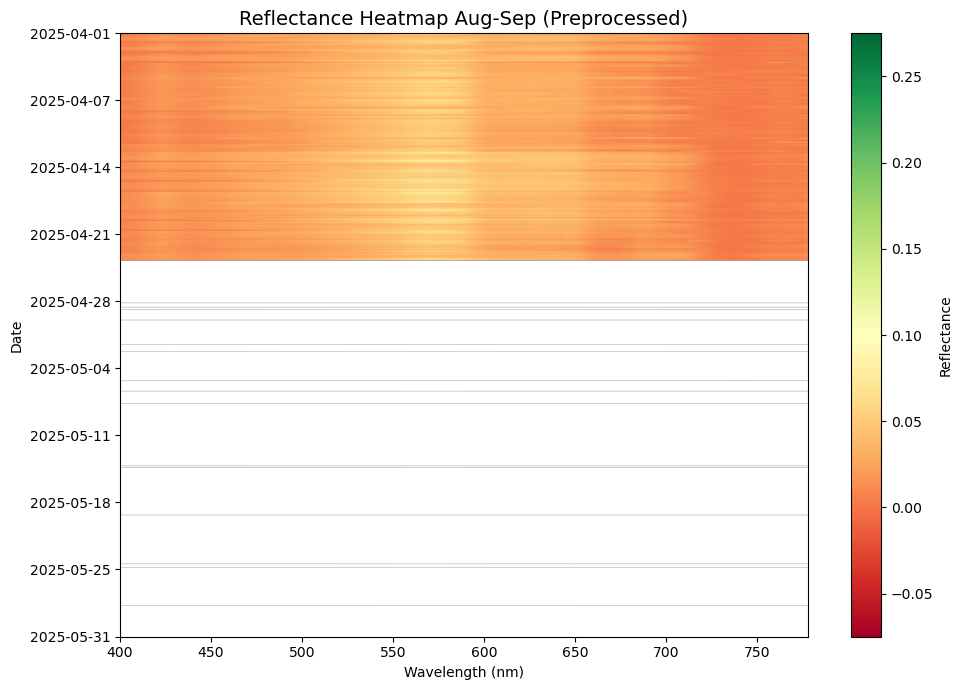

In [6]:
plot_reflectance_heatmap(
    df,
    title="Reflectance Heatmap Aug-Sep (Preprocessed)",
)

In [7]:
df = df_ready_for_moment.copy()
spec_cols = [c for c in df.columns if c != "timestamp"]

print("rows:", len(df), "features:", len(spec_cols))
print("fully-NaN rows:", df[spec_cols].isna().all(axis=1).sum())
print("any-NaN rows:", df[spec_cols].isna().any(axis=1).sum())

valid = ~df[spec_cols].isna().any(axis=1)
runs = (valid != valid.shift()).cumsum()
max_run = valid.groupby(runs).sum().max()

print("Longest contiguous fully-valid run:", int(max_run))

df = df_ready_for_moment.copy()
spec_cols = [c for c in df.columns if c != "timestamp"]

# keep ONLY rows that have no NaNs across spectrum
df_train = df.loc[~df[spec_cols].isna().any(axis=1)].reset_index(drop=True)

print("train rows:", len(df_train))

df_train

rows: 2745 features: 379
fully-NaN rows: 1696
any-NaN rows: 1696
Longest contiguous fully-valid run: 1034
train rows: 1049


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2025-04-01 07:00:00+07:00,0.001028,0.001252,0.001631,0.002151,0.002798,0.003557,0.004413,0.005351,0.006358,...,0.003903,0.003545,0.003151,0.002730,0.002288,0.001835,0.001377,0.000924,0.000483,0.000062
1,2025-04-01 07:15:00+07:00,0.001816,0.001444,0.001316,0.001411,0.001710,0.002191,0.002834,0.003618,0.004524,...,0.006354,0.006246,0.006138,0.006045,0.005977,0.005948,0.005969,0.006055,0.006216,0.006466
2,2025-04-01 07:30:00+07:00,0.005216,0.004338,0.003764,0.003469,0.003430,0.003620,0.004017,0.004596,0.005331,...,0.005148,0.004928,0.004743,0.004613,0.004555,0.004590,0.004736,0.005012,0.005437,0.006030
3,2025-04-01 07:45:00+07:00,0.001160,0.000594,0.000311,0.000288,0.000499,0.000921,0.001528,0.002296,0.003201,...,0.002718,0.002488,0.002314,0.002204,0.002167,0.002213,0.002352,0.002591,0.002941,0.003412
4,2025-04-01 08:00:00+07:00,0.003187,0.003371,0.003642,0.003994,0.004419,0.004912,0.005466,0.006074,0.006729,...,0.003281,0.003293,0.003316,0.003346,0.003383,0.003424,0.003468,0.003512,0.003555,0.003595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,2025-05-14 16:45:00+07:00,0.004920,0.004837,0.004746,0.004653,0.004565,0.004488,0.004426,0.004388,0.004378,...,0.006922,0.006949,0.006993,0.007057,0.007145,0.007258,0.007401,0.007576,0.007785,0.008033
1045,2025-05-19 14:30:00+07:00,0.011706,0.011558,0.011419,0.011294,0.011186,0.011098,0.011034,0.010996,0.010989,...,0.007035,0.007026,0.007032,0.007058,0.007107,0.007182,0.007288,0.007427,0.007605,0.007824
1046,2025-05-24 13:45:00+07:00,0.017234,0.016427,0.015758,0.015224,0.014821,0.014548,0.014400,0.014374,0.014468,...,0.004604,0.004933,0.005425,0.006096,0.006964,0.008043,0.009350,0.010901,0.012711,0.014799
1047,2025-05-24 17:45:00+07:00,0.015856,0.014513,0.013369,0.012417,0.011650,0.011063,0.010647,0.010396,0.010303,...,0.004851,0.004594,0.004326,0.004058,0.003800,0.003564,0.003361,0.003201,0.003095,0.003055


In [8]:
# Your df_ready_for_moment is already created from the previous step.
SEQ_LEN = 512       # Window size for the model. 512 is a good default for MOMENT.
NUM_EPOCHS = 5      # Number of times to loop through the data. Start with 5-10.
OUTPUT_DIR = "finetuned_model"

# Run the fine-tuning process
print("\nStarting model fine-tuning...")
finetuned_model = finetune_reflectance(
    seq_len=SEQ_LEN, 
    num_epochs=NUM_EPOCHS, 
    input_dataframe=df_train  # <-- Here is where you use your dataframe
)
print("Fine-tuning complete.")

# Step 3: Save Your New, Specialized Model
os.makedirs(OUTPUT_DIR, exist_ok=True)
model_save_path = os.path.join(OUTPUT_DIR, f"reflectance_imputer_epoch_{NUM_EPOCHS}.pt")
torch.save(finetuned_model.state_dict(), model_save_path)

print(f"\nYour fine-tuned model has been saved to: {model_save_path}")


Starting model fine-tuning...
Using device: cpu
Starting fine-tuning... Train batches: 1, Val batches: 1


Epoch 1 - Training:   0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [9]:
# --- Step 1: Load Your Fine-Tuned Model ---

# Ensure this path points to your saved model file
MODEL_PATH = "finetuned_model/reflectance_imputer_epoch_5.pt" 

# Load the base architecture
inference_model = MOMENTPipeline.from_pretrained("AutonLab/MOMENT-1-large")

# Load your custom, fine-tuned weights into the architecture
inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

# Set up the model for inference
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
inference_model = inference_model.to(device).float()
inference_model.eval() # Set model to evaluation mode

# --- Step 2: Prepare the Data ---

# Use the dataframe that has partials filled but full gaps remaining as NaN
# For example, loading it from a file if you saved it:
# df_ready_for_moment = pd.read_csv('df_ready_for_moment.csv', parse_dates=['timestamp'])
df = df_ready_for_moment.copy() 
df = df.sort_values("timestamp").set_index("timestamp")

spec_cols = [c for c in df.columns if c != "timestamp"]
T = len(df)

# Use the same window size you fine-tuned with
win = 512
stride = win // 2 # Use overlap for smooth stitching

X_spec = df[spec_cols].values.astype(np.float32)
mask_spec = np.isnan(X_spec)
X_fill = np.nan_to_num(X_spec, nan=0.0)

# --- Step 3: Create Batches and Run Inference ---

# Pad for even windowing
if T % stride != 0:
    pad_len = stride - (T % stride)
    X_fill_padded = np.pad(X_fill, ((0, pad_len), (0, 0)), 'constant', constant_values=0)
else:
    X_fill_padded = X_fill
T_padded = X_fill_padded.shape[0]

starts = np.arange(0, T_padded - win + 1, stride)
Xs = []
for s in starts:
    seg = X_fill_padded[s:s+win, :].T
    Xs.append(seg[:, None, :])

X_batch = np.concatenate(Xs, axis=0)

with torch.no_grad():
    x_enc = torch.tensor(X_batch, dtype=torch.float32, device=device)
    input_mask = torch.ones(x_enc.shape[0], x_enc.shape[-1], device=device, dtype=torch.long)
    out = inference_model(x_enc=x_enc, input_mask=input_mask)

recon = out.reconstruction.detach().cpu().numpy().squeeze(1)

# --- Step 4: Smooth Stitching with Weighted Averaging ---

stitching_window = triang(win).reshape(-1, 1)
imputed_padded = np.zeros_like(X_fill_padded, dtype=float)
counts = np.zeros_like(X_fill_padded, dtype=float)
ptr = 0

for s in starts:
    block = recon[ptr : ptr + len(spec_cols), :].T
    imputed_padded[s : s + win, :] += block * stitching_window
    counts[s : s + win, :] += stitching_window
    ptr += len(spec_cols)

imputed_padded /= (counts + 1e-8)
imputed = imputed_padded[:T, :]

# --- Step 5: Finalize and Visualize ---

# Fill only the large gaps identified by the original mask
filled = X_spec.copy()
filled[mask_spec] = imputed[mask_spec]

df_final_imputed = df.copy()
df_final_imputed[spec_cols] = np.clip(filled, 0, None)

print("\nImputation with fine-tuned model complete!")

Using device: cpu

Imputation with fine-tuned model complete!


In [10]:
df_final_imputed[spec_cols].isna().sum().sum()
df_final_imputed

,400,401,402,403,404,405,406,407,408,409,...,769,770,771,772,773,774,775,776,777,778
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-04-01 07:00:00+07:00,0.001028,0.001252,0.001631,0.002151,0.002798,0.003557,0.004413,0.005351,0.006358,0.007418,...,0.003903,0.003545,0.003151,0.002730,0.002288,0.001835,0.001377,0.000924,0.000483,0.000062
2025-04-01 07:15:00+07:00,0.001816,0.001444,0.001316,0.001411,0.001710,0.002191,0.002834,0.003618,0.004524,0.005529,...,0.006354,0.006246,0.006138,0.006045,0.005977,0.005948,0.005969,0.006055,0.006216,0.006466
2025-04-01 07:30:00+07:00,0.005216,0.004338,0.003764,0.003469,0.003430,0.003620,0.004017,0.004596,0.005331,0.006200,...,0.005148,0.004928,0.004743,0.004613,0.004555,0.004590,0.004736,0.005012,0.005437,0.006030
2025-04-01 07:45:00+07:00,0.001160,0.000594,0.000311,0.000288,0.000499,0.000921,0.001528,0.002296,0.003201,0.004218,...,0.002718,0.002488,0.002314,0.002204,0.002167,0.002213,0.002352,0.002591,0.002941,0.003412
2025-04-01 08:00:00+07:00,0.003187,0.003371,0.003642,0.003994,0.004419,0.004912,0.005466,0.006074,0.006729,0.007424,...,0.003281,0.003293,0.003316,0.003346,0.003383,0.003424,0.003468,0.003512,0.003555,0.003595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31 17:00:00+07:00,0.000214,0.000200,0.000189,0.000180,0.000172,0.000167,0.000164,0.000163,0.000163,0.000165,...,0.000080,0.000080,0.000082,0.000084,0.000088,0.000093,0.000101,0.000111,0.000123,0.000139
2025-05-31 17:15:00+07:00,0.000231,0.000216,0.000204,0.000194,0.000185,0.000180,0.000176,0.000174,0.000174,0.000176,...,0.000092,0.000093,0.000094,0.000096,0.000100,0.000106,0.000114,0.000126,0.000140,0.000157
2025-05-31 17:30:00+07:00,0.000272,0.000255,0.000240,0.000228,0.000219,0.000213,0.000208,0.000207,0.000207,0.000209,...,0.000098,0.000099,0.000101,0.000105,0.000111,0.000120,0.000132,0.000148,0.000168,0.000191


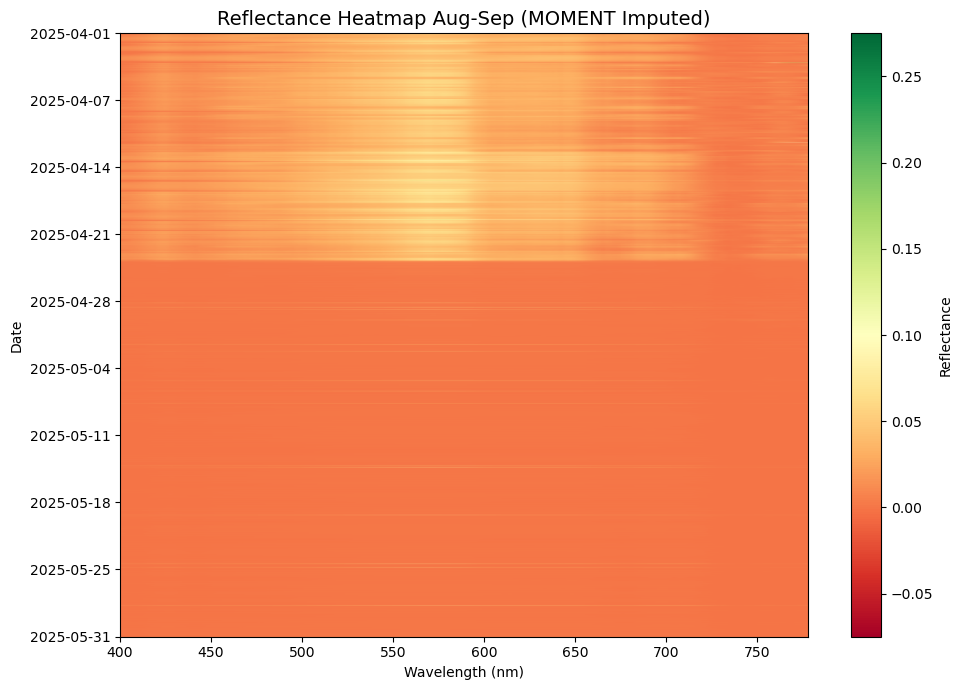

In [11]:
df_final_imputed = df_final_imputed.reset_index()
plot_reflectance_heatmap(
    df_final_imputed,
    title="Reflectance Heatmap Aug-Sep (MOMENT Imputed)",
)

In [12]:
df_final_imputed.to_csv("imputed_MOMENT_with_finetune.csv", index=False)